In [1]:
!pip install -q transformers
!pip install -q gradio
!sudo apt-get install git-lfs
!git lfs install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 65 not upgraded.
Need to get 3316 kB of archives.
After this operation, 11.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 git-lfs amd64 2.9.2-1 [3316 kB]
Fetched 3316 kB in 0s (9246 kB/s)
Selecting previously unselected package git-lfs.
(Reading database ... 108827 files and directories currently installed.)
Preparing to unpack .../git-lfs_2.9.2-1_amd64.deb ...
Unpacking git-lfs (2.9.2-1) ...
Setting up git-lfs (2.9.2-1) ...
Processing triggers for man-db (2.9.1-1) ...
Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


In [5]:
import os
import wandb
import torch
import pickle
import numpy as np
%matplotlib inline
import pandas as pd
#import gradio as gr
import seaborn as sns
import tensorflow as tf
from typing import Dict
from ast import literal_eval
from torch.optim import AdamW
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from kaggle_secrets import UserSecretsClient
from torch.nn import BCEWithLogitsLoss, BCELoss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
from transformers import XLNetForSequenceClassification, XLNetTokenizer,BertForSequenceClassification,BertTokenizer, RobertaForSequenceClassification,RobertaTokenizer

# pd.set_option('Display.max_colwidth',None)

In [6]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [7]:
torch.__version__

'1.11.0'

In [8]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2022-09-24 18:19:38.265741: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-24 18:19:38.335678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 18:19:38.336777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 18:19:38.337519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [34]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("59ea55d953c59be73504534f45c12c57cd3c2501")
    wandb.login(key=secret_value_0)
    anony=None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    
    
    
wandb.init(project="my-awesome-project")

If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. 
Get your W&B access token from here: https://wandb.ai/authorize


In [35]:
dataset_Name='../input/pubmed-multilabel-text-classification/PubMed Multi Label Text Classification Dataset Processed.csv'

df= pd.read_csv(dataset_Name)
df.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,E,F,G,H,I,J,L,M,N,Z
0,Expression of p53 and coexistence of HPV in pr...,Fifty-four paraffin embedded tissue sections f...,"['DNA Probes, HPV', 'DNA, Viral', 'Female', 'H...",8549602,"[['D13.444.600.223.555', 'D27.505.259.750.600....","['Chemicals and Drugs [D]', 'Organisms [B]', '...",0,1,1,1,1,0,0,1,0,0,0,0,0,0
1,Vitamin D status in pregnant Indian women acro...,The present cross-sectional study was conducte...,"['Adult', 'Alkaline Phosphatase', 'Breast Feed...",21736816,"[['M01.060.116'], ['D08.811.277.352.650.035'],...","['Named Groups [M]', 'Chemicals and Drugs [D]'...",0,1,1,1,1,1,1,0,1,1,0,1,1,1
2,[Identification of a functionally important di...,The occurrence of individual amino acids and d...,"['Amino Acid Sequence', 'Analgesics, Opioid', ...",19060934,"[['G02.111.570.060', 'L01.453.245.667.060'], [...","['Phenomena and Processes [G]', 'Information S...",1,1,0,1,1,0,1,0,0,0,1,0,0,0


In [36]:
print("Total number of Articles extracted from Bioasq dataset are =",len(df))

Total number of Articles extracted from Bioasq dataset are = 50000


In [37]:
print('Average Article length: ', df.abstractText.str.split().str.len().mean())
print('Stdev Article length: ', df.abstractText.str.split().str.len().std())

Average Article length:  192.05284
Stdev Article length:  76.74764082329723


In [38]:
cols = df.columns
cols = list(df.columns)
mesh_Heading_categories = cols[6:]
num_labels = len(mesh_Heading_categories)
print('Mesh Labels Root Class: "\n"',mesh_Heading_categories)
print("\n")
print('Number of Labels: ' ,num_labels)


Mesh Labels Root Class: "
" ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'Z']


Number of Labels:  14


In [39]:
%%time

counts = []
for mesh_Heading_category in mesh_Heading_categories:
    counts.append((mesh_Heading_category, df[mesh_Heading_category].sum()))
df_count = pd.DataFrame(counts, columns=['Root Label', 'number of Abstract'])
df_count

CPU times: user 281 ms, sys: 68.4 ms, total: 350 ms
Wall time: 443 ms


,Root Label,number of Abstract
0,A,23263
1,B,46577
2,C,26453
3,D,31074
4,E,39202
5,F,8885
6,G,33609
7,H,6069
8,I,5595
9,J,5531


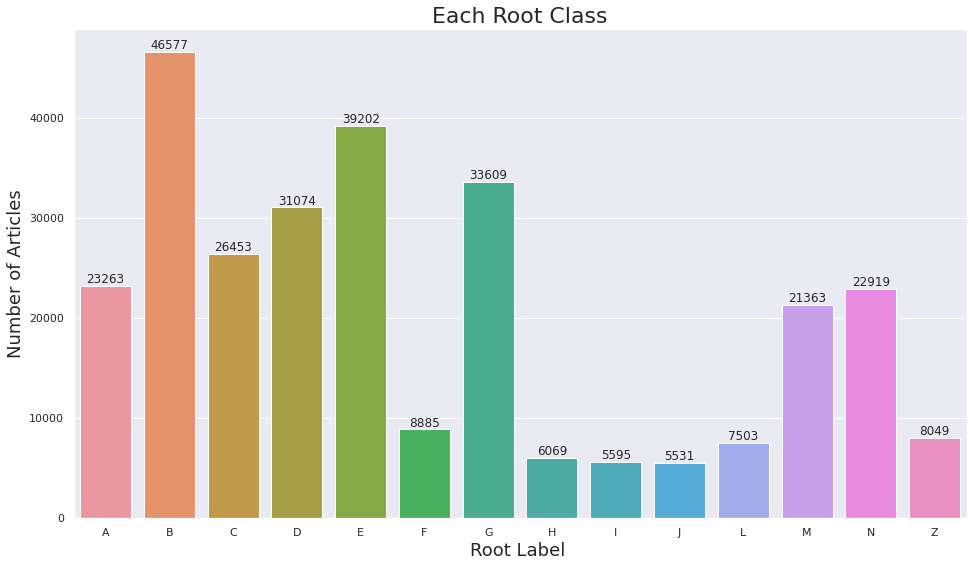

CPU times: user 419 ms, sys: 53.2 ms, total: 472 ms
Wall time: 451 ms


In [40]:
%%time
sns.set(font_scale = 1)
plt.figure(figsize=(16,9))
ax= sns.barplot(mesh_Heading_categories, df.iloc[:,6:].sum().values)
plt.title("Each Root Class", fontsize=22)
plt.ylabel('Number of Articles', fontsize=18)
plt.xlabel('Root Label ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = df.iloc[:,6:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=12)

plt.show()

In [41]:
df_train, df_test = train_test_split(df, random_state=32, test_size=0.20, shuffle=True)

print(df_train.shape)
print(df_test.shape)
del(df)

(40000, 20)
(10000, 20)


In [42]:
df_train['one_hot_labels'] = list(df_train[mesh_Heading_categories].values)
df_train.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
31112,Neurofibromatosis associated with a coronary a...,A case of a patient with type 1 neurofibromato...,"['Aged', 'Coronary Aneurysm', 'Humans', 'Male'...",11144803,"[['M01.060.116.100'], ['C14.280.647.250.250', ...","['Named Groups [M]', 'Diseases [C]', 'Organism...",0,1,1,0,...,0,0,0,0,0,0,1,0,0,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
48911,Phenolic constituents from Perovskia atriplici...,"Perovskoate, an isorinic acid derivative (1) a...","['Caffeic Acids', 'Catechols', 'Cholinesterase...",16644529,"[['D02.241.223.200.054'], ['D02.455.426.559.38...","['Chemicals and Drugs [D]', 'Analytical, Diagn...",0,1,0,1,...,0,1,0,0,0,0,0,0,0,"[0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
16394,Motion artifact and background noise suppressi...,Optical coherence tomography (OCT) is a techni...,"['Algorithms', 'Angiography', 'Artifacts', 'Ar...",25089975,"[['G17.035', 'L01.224.050'], ['E01.370.350.700...","['Phenomena and Processes [G]', 'Information S...",0,0,0,0,...,0,1,0,0,0,1,0,1,0,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0]"


In [43]:
labels = list(df_train.one_hot_labels.values)
Article_train = list(df_train.abstractText.values)

In [44]:
%%time
max_length = 128
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False) 

encodings = tokenizer.batch_encode_plus(Article_train,max_length=max_length,padding=True,truncation=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
CPU times: user 1min 27s, sys: 455 ms, total: 1min 28s
Wall time: 1min 29s


In [26]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow me to stratify split our training data later
label_counts = df_train.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df_train[df_train.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [49950, 49878, 49876, 49838, 49759, 49739, 49696, 49590, 49585, 49574, 49546, 49535, 49528, 49487, 49470, 49419, 49404, 49395, 49314, 49245, 49150, 49080, 49071, 49058, 49004, 48991, 48982, 48922, 48919, 48757, 48708, 48686, 48679, 48677, 48602, 48594, 48583, 48531, 48454, 48438, 48411, 48388, 48375, 48350, 48337, 48298, 48213, 48185, 48123, 48085, 48075, 48056, 48020, 48001, 47876, 47840, 47828, 47817, 47776, 47671, 47495, 47435, 47369, 47363, 47362, 47359, 47356, 47321, 47293, 47244, 47239, 47159, 47104, 47089, 47061, 47050, 47002, 46955, 46887, 46874, 46837, 46747, 46706, 46651, 46635, 46598, 46446, 46365, 46247, 46223, 46199, 46170, 46033, 46028, 45955, 45946, 45756, 45755, 45712, 45682, 45671, 45573, 45509, 45430, 45391, 45317, 45294, 45226, 45216, 45190, 45134, 45132, 45105, 45052, 45035, 45025, 44971, 44953, 44867, 44851, 44827, 44777, 44763, 44625, 44606, 44598, 44586, 44579, 44574, 44568, 44499, 44479, 44462, 44296, 44206, 44181, 44116

In [27]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=2020, test_size=0.20)

# Convert all of our data into torch tensors, the required datatype for our XLNet Pytorch model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:207.)
  


In [28]:
batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data =     TensorDataset(train_inputs, train_masks, train_labels,)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [29]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

In [30]:
%%time
#Tried Several Models Locally XLNet was performing Best. Note If you are changing the model then change the Tokenizer also
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_labels)

model.cuda()
print('Model Pushed to Cuda for Training')

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Model Pushed to Cuda for Training
CPU times: user 9.74 s, sys: 1.63 s, total: 11.4 s
Wall time: 12 s


In [45]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [46]:
optimizer = AdamW(model.parameters(),lr=4e-5)  # Default optimization #XL-NET

In [47]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

In [48]:
%%time

# For Storing our loss and accuracy for plotting
train_loss_set = []
val_f1_accuracy_list,val_flat_accuracy_list,training_loss_list,epochs_list=[],[],[],[]

# Number of training epochs (Orignal author's recommend between 10 and 20)
epochs = 12

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch "):
    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels= batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # Forward pass for multilabel classification
        # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
        # Creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities
        # Also This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable 
        # than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the 
        # log-sum-exp trick for numerical stability.
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        loss_func = BCEWithLogitsLoss() 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    training_loss_list.append(tr_loss/nb_tr_steps)

    ###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    # Predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)  
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    print('\n')
    val_f1_accuracy_list.append(val_f1_accuracy)
    val_flat_accuracy_list.append(val_flat_accuracy)
    epochs_list.append(epochs)  
    
    wandb.log({"train_loss":tr_loss/nb_tr_steps,"val_f1_accuracy":val_f1_accuracy,"val_flat_accuracy":val_flat_accuracy,})
wandb.finish()

Epoch :   0%|          | 0/12 [00:00<?, ?it/s]

Train loss: 0.3314138961434364


Epoch :   8%|▊         | 1/12 [08:28<1:33:13, 508.52s/it]

F1 Validation Accuracy:  85.03496503496504
Flat Validation Accuracy:  20.3125


Train loss: 0.2831129242181778


Epoch :  17%|█▋        | 2/12 [16:56<1:24:44, 508.41s/it]

F1 Validation Accuracy:  85.98901098901099
Flat Validation Accuracy:  15.625


Train loss: 0.259588208258152


Epoch :  25%|██▌       | 3/12 [25:25<1:16:15, 508.44s/it]

F1 Validation Accuracy:  85.28610354223434
Flat Validation Accuracy:  14.0625


Train loss: 0.23548530972003937


Epoch :  33%|███▎      | 4/12 [33:53<1:07:48, 508.52s/it]

F1 Validation Accuracy:  85.3625170998632
Flat Validation Accuracy:  18.75


Train loss: 0.21099761140346526


Epoch :  42%|████▏     | 5/12 [42:22<59:20, 508.62s/it]  

F1 Validation Accuracy:  85.6353591160221
Flat Validation Accuracy:  12.5


Train loss: 0.18378661280870437


Epoch :  50%|█████     | 6/12 [50:51<50:52, 508.71s/it]

F1 Validation Accuracy:  84.78260869565217
Flat Validation Accuracy:  15.625


Train loss: 0.15760502375662327


Epoch :  58%|█████▊    | 7/12 [59:20<42:23, 508.76s/it]

F1 Validation Accuracy:  83.93351800554017
Flat Validation Accuracy:  14.0625


Train loss: 0.13126071241497994


Epoch :  67%|██████▋   | 8/12 [1:07:49<33:55, 508.79s/it]

F1 Validation Accuracy:  84.60471567267683
Flat Validation Accuracy:  14.0625


Train loss: 0.10748197846114635


Epoch :  75%|███████▌  | 9/12 [1:16:18<25:26, 508.77s/it]

F1 Validation Accuracy:  82.94679399727148
Flat Validation Accuracy:  14.0625


Train loss: 0.08852154146879912


Epoch :  83%|████████▎ | 10/12 [1:24:46<16:57, 508.76s/it]

F1 Validation Accuracy:  84.12256267409472
Flat Validation Accuracy:  17.1875


Train loss: 0.0713023571446538


Epoch :  92%|█████████▏| 11/12 [1:33:15<08:28, 508.73s/it]

F1 Validation Accuracy:  84.06593406593407
Flat Validation Accuracy:  18.75


Train loss: 0.0583590067923069


Epoch : 100%|██████████| 12/12 [1:41:44<00:00, 508.67s/it]

F1 Validation Accuracy:  82.74932614555256
Flat Validation Accuracy:  12.5




train_loss,█▇▆▆▅▄▄▃▂▂▁▁
val_f1_accuracy,▆█▆▇▇▅▄▅▁▄▄▁
val_flat_accuracy,█▄▂▇▁▄▂▂▂▅▇▁
train_loss,0.05836
val_f1_accuracy,82.74933
val_flat_accuracy,12.5


CPU times: user 1h 41min 13s, sys: 7.19 s, total: 1h 41min 20s
Wall time: 1h 41min 47s


In [50]:
num_epochs = np.arange(1,len(training_loss_list)+1)
df_train_results=pd.DataFrame({'Epochs':num_epochs,'F1 Validation Accuracy':val_f1_accuracy_list,\
                               'Flat Validation Accuracy':val_flat_accuracy_list,'Train loss':training_loss_list})

Text(0.5, 1.0, 'Training Loss vs Number of Epochs for XLNet')

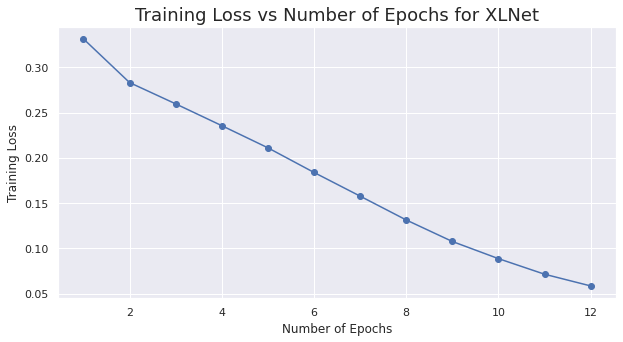

In [51]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(training_loss_list) ,'bo-',label="Train Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Training Loss")
ax.set_title("Training Loss vs Number of Epochs for XLNet",fontsize=18)

(0.0, 100.0)

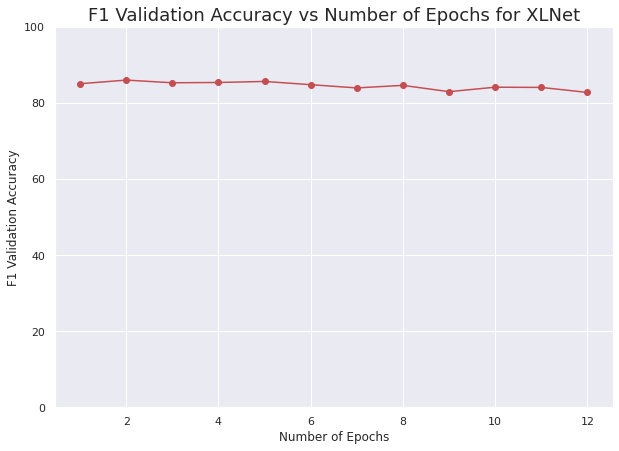

In [53]:
fig, ax = plt.subplots(figsize=(10, 7));
ax.plot(num_epochs, np.array(val_f1_accuracy_list),'ro-' ,label="F1 Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("F1 Validation Accuracy")
ax.set_title("F1 Validation Accuracy vs Number of Epochs for XLNet",fontsize=18)
ax.set_ylim(0, 100)

(0.0, 100.0)

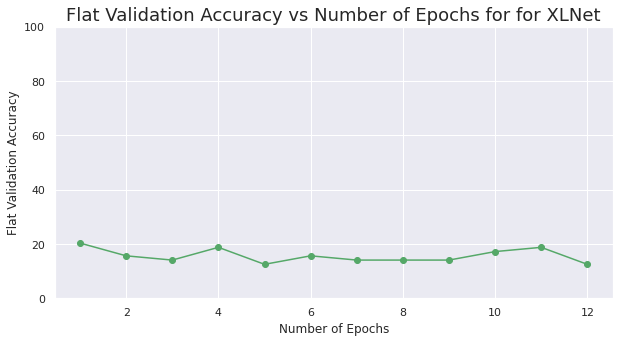

In [54]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(val_flat_accuracy_list),'go-', label="Flat Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Flat Validation Accuracy")
ax.set_title("Flat Validation Accuracy vs Number of Epochs for for XLNet",fontsize=18)
ax.set_ylim(0, 100)

In [55]:
df_test['one_hot_labels'] = list(df_test[mesh_Heading_categories].values)
df_test.head(3)

,Title,abstractText,meshMajor,pmid,meshid,meshroot,A,B,C,D,...,F,G,H,I,J,L,M,N,Z,one_hot_labels
35083,Expression of N-methyl-d-aspartate receptor 1 ...,High levels of glutamate can be toxic to retin...,"['Analysis of Variance', 'Animals', 'Cell Deat...",17942238,"[['E05.318.740.150', 'N05.715.360.750.125', 'N...","['Analytical, Diagnostic and Therapeutic Techn...",1,1,1,1,...,0,1,0,0,0,0,0,1,0,"[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
9005,Protection of pregnant swine by vaccination ag...,The protection conferred on pregnant gilts by ...,"['Animals', 'Antibodies, Bacterial', 'Bacteria...",7150130,"[['B01.050'], ['D12.776.124.486.485.114.107', ...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",0,1,1,1,...,0,1,0,0,0,0,0,1,0,"[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
23836,An examination of Escherichia coli strains iso...,Ninety-five strains of Escherichia coli isolat...,"['Animals', 'Antigens', 'Antigens, Bacterial',...",6135266,"[['B01.050'], ['D23.050'], ['D23.050.161'], ['...","['Organisms [B]', 'Chemicals and Drugs [D]', '...",1,1,1,1,...,0,1,0,0,0,0,0,0,0,"[1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"


In [56]:
test_labels = list(df_test.one_hot_labels.values)
Articles_test = list(df_test.abstractText.values)
test_mesh_categories = list(df_test.columns[6:20])

In [57]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(Articles_test,max_length=max_length,padding=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

In [58]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels,)# test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

In [59]:
%%time

# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, = batch
    with torch.no_grad():
        # Forward pass
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

CPU times: user 54 s, sys: 44 ms, total: 54 s
Wall time: 54.2 s


In [60]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding
# Print and save classification report
Test_F1_Accuracy=f1_score(true_bools, pred_bools,average='micro')
Test_Flat_Accuracy= accuracy_score(true_bools, pred_bools)
print('Test F1 Accuracy: ',Test_F1_Accuracy )
print('Test Flat Accuracy: ',Test_Flat_Accuracy,'\n')

df_test=pd.DataFrame({'Test F1 Accuracy':Test_F1_Accuracy, 'Test Flat Accuracy':Test_Flat_Accuracy},index=[0])

print(classification_report(true_bools,pred_bools,target_names=test_mesh_categories))
clf_report = classification_report(true_bools,pred_bools,target_names=test_mesh_categories,output_dict=True)
df_report=pd.DataFrame(clf_report).transpose()



Test F1 Accuracy:  0.834202672894771
Test Flat Accuracy:  0.133 

              precision    recall  f1-score   support

           A       0.76      0.80      0.78      4609
           B       0.96      0.98      0.97      9250
           C       0.86      0.87      0.87      5206
           D       0.89      0.94      0.92      6259
           E       0.84      0.84      0.84      7778
           F       0.74      0.78      0.76      1767
           G       0.83      0.84      0.84      6799
           H       0.39      0.39      0.39      1221
           I       0.63      0.65      0.64      1068
           J       0.62      0.62      0.62      1110
           L       0.59      0.52      0.55      1491
           M       0.87      0.89      0.88      4232
           N       0.74      0.82      0.78      4602
           Z       0.64      0.76      0.69      1558

   micro avg       0.82      0.85      0.83     56950
   macro avg       0.74      0.76      0.75     56950
weighted avg  

In [61]:
df_report.to_csv('Classification_Report.csv',index=False)

In [62]:
model.save_pretrained('./Multi_label_Classification_Save/')
tokenizer.save_pretrained('./Multi_label_Classification_Save/')

('./Multi_label_Classification_Save/tokenizer_config.json',
 './Multi_label_Classification_Save/special_tokens_map.json',
 './Multi_label_Classification_Save/spiece.model',
 './Multi_label_Classification_Save/added_tokens.json')

In [63]:
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("hf") ##Has kept it private. Please use your own token

In [64]:
#Converting Labels to categorical before pushing it to Hugging Face Hub
model.config.label2id= {
"Anatomy [A]": 0,
"Organisms [B]": 1,
"Diseases [C]": 2,
"Chemicals and Drugs [D]": 3,
"Analytical, Diagnostic and Therapeutic Techniques, and Equipment [E]": 4,
"Psychiatry and Psychology [F]": 5,
"Phenomena and Processes [G]": 6,
"Disciplines and Occupations [H]": 7,
"Anthropology, Education, Sociology, and Social Phenomena [I]": 8,
"Technology, Industry, and Agriculture [J]": 9,
"Information Science [L]": 10,
"Named Groups [M]": 11,
"Health Care [N]": 12,
"Geographicals [Z]": 13,
}


model.config.id2label={
    "0": "Anatomy [A]",
    "1": "Organisms [B]",
    "2": "Diseases [C]",
    "3": "Chemicals and Drugs [D]",
    "4": "Analytical, Diagnostic and Therapeutic Techniques, and Equipment [E]",
    "5": "Psychiatry and Psychology [F]",
    "6": "Phenomena and Processes [G]",
    "7": "Disciplines and Occupations [H]",
    "8": "Anthropology, Education, Sociology, and Social Phenomena [I]",
    "9": "Technology, Industry, and Agriculture [J]",
    "10": "Information Science [L]",
    "11": "Named Groups [M]",
    "12": "Health Care [N]",
    "13": "Geographicals [Z]"
}
    

In [65]:
model.push_to_hub(repo_path_or_name='saidhr20/pubmed-xlnet-text-classification',use_auth_token=secret_value_0)

Cloning https://huggingface.co/saidhr20/pubmed-xlnet-text-classification into local empty directory.


Upload file pytorch_model.bin:   0%|          | 32.0k/448M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/saidhr20/pubmed-xlnet-text-classification
   dc4f0c6..04c3acb  main -> main



'https://huggingface.co/saidhr20/pubmed-xlnet-text-classification/commit/04c3acb47f9b3f3ae3777ab7b6d7a3d0a1797df7'

In [68]:
tokenizer.push_to_hub(repo_path_or_name='saidhr20/pubmed-xlnet-text-classification',use_auth_token=secret_value_0)

Upload file spiece.model:   4%|4         | 32.0k/779k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/saidhr20/pubmed-xlnet-text-classification
   04c3acb..04321e7  main -> main



'https://huggingface.co/saidhr20/pubmed-xlnet-text-classification/commit/04321e74f17d08b68114acfef5355746d4ec0b5e'

In [69]:
tokenizer = XLNetTokenizer.from_pretrained('saidhr20/pubmed-xlnet-text-classification', do_lower_case=True) 

In [70]:
num_labels=14
model = XLNetForSequenceClassification.from_pretrained("saidhr20/pubmed-xlnet-text-classification", num_labels=num_labels)

In [71]:
!pip install gradio


In [72]:
import gradio as gr
def Multi_Label_Classification_of_Pubmed_Articles(model_input: str) -> Dict[str, float]:
    
    # Encoding input data
    dict_custom={}
    Preprocess_part1=model_input[:len(model_input)]
    Preprocess_part2=model_input[len(model_input):]
    dict1=tokenizer.encode_plus(Preprocess_part1,max_length=1024,padding=True,truncation=True)
    dict2=tokenizer.encode_plus(Preprocess_part2,max_length=1024,padding=True,truncation=True)
    
    dict_custom['input_ids']=[dict1['input_ids'],dict1['input_ids']]
    dict_custom['token_type_ids']=[dict1['token_type_ids'],dict1['token_type_ids']]
    dict_custom['attention_mask']=[dict1['attention_mask'],dict1['attention_mask']]
    
    outs = model(torch.tensor(dict_custom['input_ids']), token_type_ids=None, attention_mask=torch.tensor(dict_custom['attention_mask']))
    b_logit_pred = outs[0]
    pred_label = torch.sigmoid(b_logit_pred)
    
    ret ={
        "Anatomy [A]": float(pred_label[0][0]),
        "Organisms [B]": float(pred_label[0][1]),
        "Diseases [C]": float(pred_label[0][2]),
        "Chemicals and Drugs [D]": float(pred_label[0][3]),
        "Analytical, Diagnostic and Therapeutic Techniques, and Equipment [E]": float(pred_label[0][4]),
        "Psychiatry and Psychology [F]": float(pred_label[0][5]),
        "Phenomena and Processes [G]": float(pred_label[0][6]),
        "Disciplines and Occupations [H]": float(pred_label[0][7]),
        "Anthropology, Education, Sociology, and Social Phenomena [I]": float(pred_label[0][8]),
        "Technology, Industry, and Agriculture [J]": float(pred_label[0][9]),
        "Information Science [L]": float(pred_label[0][10]),
        "Named Groups [M]": float(pred_label[0][11]),
        "Health Care [N]": float(pred_label[0][12]),
        "Geographicals [Z]": float(pred_label[0][13])}
    return ret


model_input = gr.Textbox("Input text here )", show_label=False)
model_output = gr.Label("Multi Label MeSH(Medical Subheadings) Result", num_top_classes=6, show_label=True, label="MeSH(Medical Subheadings) Labels assigned to this article")


examples = [
    (
        "A case of a patient with type 1 neurofibromatosis associated with popliteal and coronary artery aneurysms is described in which cross-sectional",
        "imaging provided diagnostic information.",
        "The aim of this study was to compare the exercise intensity and competition load during Time Trial (TT), Flat (FL), Medium Mountain (MM) and High ",
        "Mountain (HM) stages based heart rate (HR) and session rating of perceived exertion (RPE).METHODS: We monitored both HR and RPE of 12 professional ",
        "cyclists during two consecutive 21-day cycling races in order to analyze the exercise intensity and competition load (TRIMPHR and TRIMPRPE).",
        "RESULTS:The highest (P<0.05) mean HR was found in TT (169±2 bpm) versus those observed in FL (135±1 bpm), MM (139±3 bpm), HM (143±1 bpm)"
    ),
    (
        "The association of body mass index (BMI) with blood pressure may be stronger in Asian than non-Asian populations, however, longitudinal studies ",
        "with direct comparisons between ethnicities are lacking. We compared the relationship of BMI with incident hypertension over approximately 9.5 years",
        " of follow-up in young (24-39 years) and middle-aged (45-64 years) Chinese Asians (n=5354), American Blacks (n=6076) and American Whites (n=13451).",
        "We estimated risk differences using logistic regression models and calculated adjusted incidences and incidence differences. ",
        "To facilitate comparisons across ethnicities, standardized estimates were calculated using mean covariate values for age, sex, smoking, education",
        "and field center, and included the quadratic terms for BMI and age. Weighted least-squares regression models with were constructed to summarize",
        "ethnic-specific incidence differences across BMI. Wald statistics and p-values were calculated based on chi-square distributions. The association of",
        "BMI with the incidence difference for hypertension was steeper in Chinese (p<0.05) than in American populations during young and middle-adulthood.",
        "For example, at a BMI of 25 vs 21 kg/m2 the adjusted incidence differences per 1000 persons (95% CI) in young adults with a BMI of 25 vs those with",
        "a BMI of 21 was 83 (36- 130) for Chinese, 50 (26-74) for Blacks and 30 (12-48) for Whites"
    )
]

title = "XLnet Classification of biomedical article Pubmed"
description = "The traditional machine learning models give a lot of pain when we do not have sufficient labeled data for the specific task or domain we care about to train a reliable model. Transfer learning allows us to deal with these scenarios by leveraging the already existing labeled data of some related task or domain. We try to store this knowledge gained in solving the source task in the source domain and apply it to our problem of interest. In this work, We have utilized Transfer Learning utilizing XLnet a model to fine tune on Pubmed MultiLabel classification Dataset."
text1 = (
    "<center> Authors:  Said and Aymen's Master Thesis at <b> University Saad dahblab Blida </b></center>"

)



app = gr.Interface(
    Multi_Label_Classification_of_Pubmed_Articles, 
	inputs=model_input,
    outputs=model_output, 
    examples=examples,
    title=title,
	description=description,
    article=text1,
    allow_flagging='never',
    analytics_enabled=False,
)


app.launch(inline=True,share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://26439.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7fca1f46c1d0>,
 'http://127.0.0.1:7860/',
 'https://26439.gradio.app')